Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
TraningPath = "/content/gdrive/MyDrive/Train"

data_dir_train = pathlib.Path(TraningPath)
#data_dir_test = pathlib.Path('CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
#image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
#print(image_count_test)

2247


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False)

Found 2247 files belonging to 9 classes.
Using 1798 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False)

Found 2247 files belonging to 9 classes.
Using 449 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

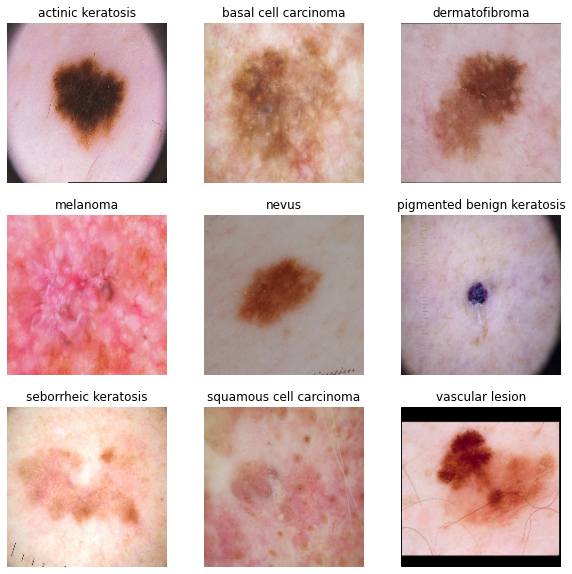

In [9]:
import matplotlib.pyplot as plt
num_classes=9
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# model architecture


model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(9, activation='softmax'))

Minimum and maximum pixel values: 0.0 1.0


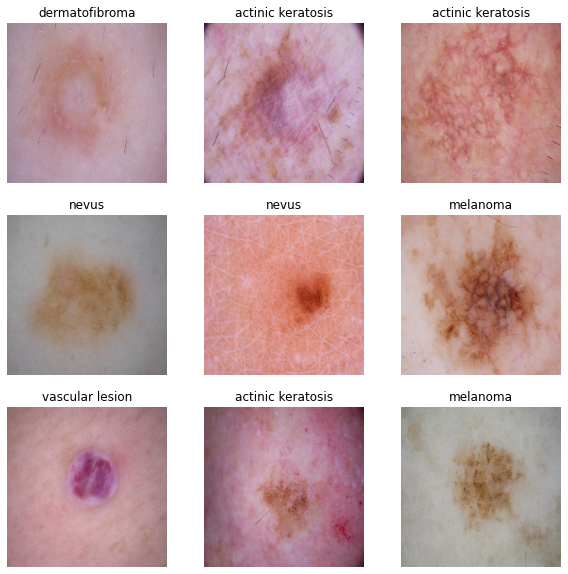

In [12]:
## Lets resize and rescale the pixels to [0-1], verify the pixels are in [0-1]

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255)
])

image, label = next(iter(train_ds))

plt.figure(figsize=(10, 10))
result = resize_and_rescale(image)

print("Minimum and maximum pixel values:", result.numpy().min(), result.numpy().max())

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image[i].numpy().astype("uint8"))
  plt.title(class_names[label[i]])
  plt.axis("off")

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


57/57 [==============================] - 7s 79ms/step - loss: 2.3662 - accuracy: 0.2397 - val_loss: 1.8596 - val_accuracy: 0.2873
Epoch 2/20
57/57 [==============================] - 2s 28ms/step - loss: 1.7727 - accuracy: 0.3454 - val_loss: 1.6117 - val_accuracy: 0.4499
Epoch 3/20
57/57 [==============================] - 2s 27ms/step - loss: 1.5321 - accuracy: 0.4638 - val_loss: 1.4995 - val_accuracy: 0.4833
Epoch 4/20
57/57 [==============================] - 2s 27ms/step - loss: 1.4006 - accuracy: 0.5206 - val_loss: 1.4422 - val_accuracy: 0.5100
Epoch 5/20
57/57 [==============================] - 2s 27ms/step - loss: 1.2898 - accuracy: 0.5551 - val_loss: 1.4201 - val_accuracy: 0.5011
Epoch 6/20
57/57 [==============================] - 2s 27ms/step - loss: 1.2046 - accuracy: 0.5857 - val_loss: 1.4060 - val_accuracy: 0.5100
Epoch 7/20
57/57 [==============================] - 2s 28ms/step - loss: 1.0580 - accuracy: 0.6279 - val_loss: 1.3807 - val_accuracy: 0.5234
Epoch 8/20
57/57 [======

### Visualizing training results

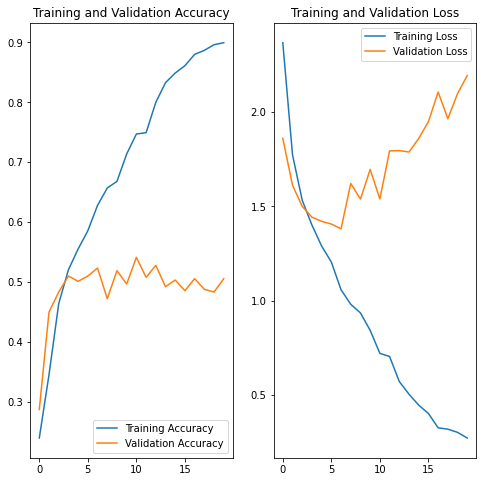

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Observation** : *Above graph shows huge overfitting wherein, after 20 epochs training accuracy gets over 92% where as validation stays arround 50%, which is clear sign of overfitting. Same can be seen in loss.*

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)



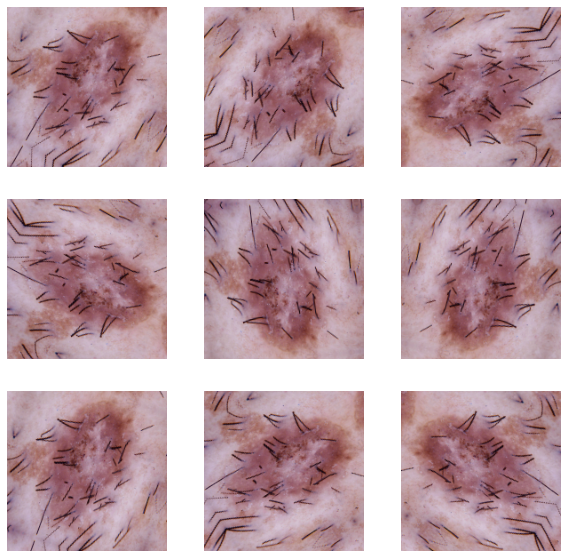

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_2 = Sequential()
model_2.add(data_augmentation)
model_2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model_2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D())
model_2.add(Dropout(0.1))

model_2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D())
model_2.add(Dropout(0.1))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation='relu'))

model_2.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [20]:

### Todo, choose an appropirate optimiser and loss function
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
#model_2.summary()

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


57/57 [==============================] - 3s 35ms/step - loss: 2.4519 - accuracy: 0.1758 - val_loss: 2.0718 - val_accuracy: 0.1470
Epoch 2/20
57/57 [==============================] - 2s 33ms/step - loss: 2.0183 - accuracy: 0.1969 - val_loss: 2.0001 - val_accuracy: 0.2205
Epoch 3/20
57/57 [==============================] - 2s 33ms/step - loss: 1.9410 - accuracy: 0.2775 - val_loss: 1.8094 - val_accuracy: 0.3318
Epoch 4/20
57/57 [==============================] - 2s 33ms/step - loss: 1.7698 - accuracy: 0.3604 - val_loss: 1.7024 - val_accuracy: 0.4009
Epoch 5/20
57/57 [==============================] - 2s 33ms/step - loss: 1.6615 - accuracy: 0.4055 - val_loss: 1.5887 - val_accuracy: 0.4477
Epoch 6/20
57/57 [==============================] - 2s 33ms/step - loss: 1.6147 - accuracy: 0.4271 - val_loss: 1.5823 - val_accuracy: 0.4365
Epoch 7/20
57/57 [==============================] - 2s 33ms/step - loss: 1.5964 - accuracy: 0.4410 - val_loss: 1.6118 - val_accuracy: 0.3987
Epoch 8/20
57/57 [======

### Visualizing the results

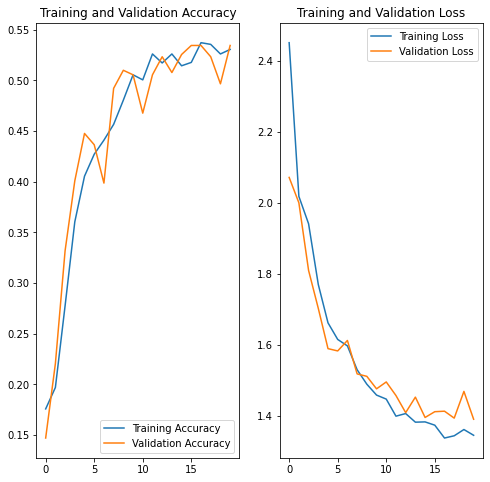

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation** : *Above graph shows no overfitting wherein, after 20 epochs training accuracy is about 58% where as validation accuracy is arround 53%, which is not a sign of overfitting. Same can be seen in loss. However, the accuracy is little on the lesser side.*

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Let's count the sample dataset n each of the classes..
#Let's capture path of all jpegs
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list[0]

#Let's capture path of all jpegs
label_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
label_list[0]

dataframe_dict = dict(zip(path_list, label_list))
main_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['path','label'])

main_df['label'].value_counts()

pigmented benign keratosis    470
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: label, dtype: int64

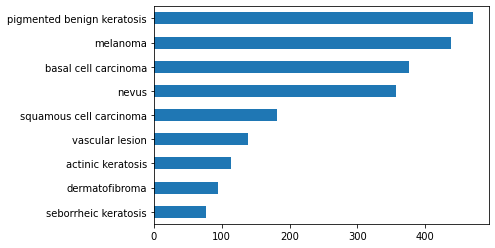

In [25]:
#Let's plot to see the spread of classes 
main_df['label'].value_counts().sort_values().plot(kind = 'barh')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Answer : seborrheic keratosis
##### --------------------------
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Answer : pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset= TraningPath
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+"/"+str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA9A1E4450>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA9A192B10>: 100%|██████████| 500/500 [00:19<00:00, 26.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA9A1C2FD0>: 100%|██████████| 500/500 [00:19<00:00, 26.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA9A1F7B90>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA9A1E46D0>:   0%|          | 1/500 [00:00<01:26,  5.79 Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FBA9A0EAD50>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA9A13F6D0>:   0%|          | 1/500 [00:00<01:07,  7.43 Samples/s]

Initialised with 470 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA9A0AEA10>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBADE0E72D0>: 100%|██████████| 500/500 [00:41<00:00, 12.07 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA9A1A2ED0>:   0%|          | 1/500 [00:00<01:21,  6.11 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB20219B50>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBACCD3A890>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB20166C90>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = main_df.append(df2)

In [33]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
nevus                         500
seborrheic keratosis          500
dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train=TraningPath
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6747 files belonging to 9 classes.
Using 5398 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6747 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
model_3 = Sequential()
model_3.add(data_augmentation)
model_3.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model_3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
#model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D())
model_3.add(Dropout(0.1))

model_3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
#model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D())
model_3.add(Dropout(0.1))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(64, activation='relu'))

model_3.add(layers.Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 35s 196ms/step - loss: 2.3405 - accuracy: 0.2401 - val_loss: 1.9183 - val_accuracy: 0.2891
Epoch 2/30
169/169 [==============================] - 34s 193ms/step - loss: 1.6494 - accuracy: 0.3814 - val_loss: 1.6023 - val_accuracy: 0.4033
Epoch 3/30
169/169 [==============================] - 33s 187ms/step - loss: 1.5039 - accuracy: 0.4279 - val_loss: 1.6311 - val_accuracy: 0.3958
Epoch 4/30
169/169 [==============================] - 33s 187ms/step - loss: 1.4587 - accuracy: 0.4420 - val_loss: 1.4603 - val_accuracy: 0.4433
Epoch 5/30
169/169 [==============================] - 33s 187ms/step - loss: 1.4072 - accuracy: 0.4668 - val_loss: 1.5579 - val_accuracy: 0.4233
Epoch 6/30
169/169 [==============================] - 33s 187ms/step - loss: 1.3577 - accuracy: 0.4748 - val_loss: 1.4794 - val_accuracy: 0.4626
Epoch 7/30
169/169 [==============================] - 33s 187ms/step - loss: 1.3311 - accuracy: 0.4956 - val_loss: 1.3229 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

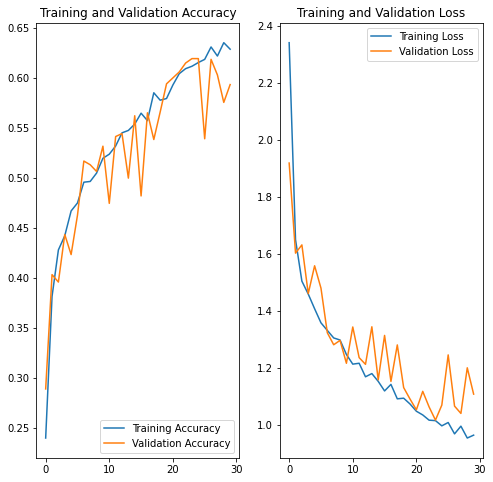

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observation** : *Above graph shows no overfitting wherein, after 30 epochs training accuracy is about 72% where as validation accuracy is arround 68%, which is not a sign of overfitting. Same can be seen in loss. There as been a significant increase in accuracy using augmentor library.
We can perform better by using more CNN units and HP tuning.
*